In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)

    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
def partial_tensor_flip(x, part_to_flip):
    np_x = x.clone().numpy()
    for i in range(np_x.shape[0]):
        if part_to_flip == 0:
            # отражаем горизонтально верхнюю половину
            np_x[i, :14, :] = np.fliplr(np_x[i, :14, :])
        elif part_to_flip == 1:
            # отражаем вертикально правую половину
            np_x[i, :, 14:] = np.flipud(np_x[i, :, 14:])
        elif part_to_flip == 2:
            # отражаем горизонтально нижнюю половину
            np_x[i, 14:, :] = np.fliplr(np_x[i, 14:, :])
        elif part_to_flip == 3:
            # отражаем вертикально левую половину
            np_x[i, :, :14] = np.flipud(np_x[i, :, :14])
    
    return torch.tensor(np_x)

### Реализация добавления шума и отражения асти изображения

In [6]:
def add_noise(x, mode='crop', noise_std=0.3, elementwise=False):
    if mode=='identity' or np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            for i in range(x.shape[0]):
                img_part = np.random.randint(4)
                x[i] = partial_tensor_flip(x[i], img_part)

        elif mode == 'gaussian':
            noise_shape = x[0].shape
            for i in range(x.shape[0]):
                x[i].add_((noise_std**0.5)*torch.randn(noise_shape))
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one

        elif mode == 'mirror':
            img_part = np.random.randint(4)
            for i in range(x.shape[0]):
                x[i] = partial_tensor_flip(x[i], img_part)

        elif mode == 'gaussian':
            noise_shape = x[0].shape
            noise = (noise_std**0.5)*torch.randn(noise_shape)
            for i in range(x.shape[0]):                
                x[i].add_(noise)
                
    return x

In [7]:
def train(epoch, model, mode='identity', noise_std=0.3, elementwise=False, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data, mode, noise_std, elementwise)        
        model.optim.zero_grad()
        output = model(noized)
        loss = model.loss(output, data)
        loss.backward()
        model.optim.step()
            
        if batch_idx % 150 == 0:
            line = f'Train Epoch: {epoch} [{batch_idx * len(data):05d}/{train_size}] '
            loss = f'{model._loss.item():.6f}'
            print(line + loss)
            
    else:
        batch_idx += 1
        line = f'Train Epoch: {epoch} [{batch_idx * len(data):05d}/{train_size}] '
        loss = f'{model._loss.item():.6f}'
        if log is not None:
            log.append(model._loss)
        print(line + loss)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(model, loader, mode='identity', noise_std=0.3, elementwise=False, log=None):
    test_size = len(loader.sampler)

    test_loss = 0.
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data, mode, noise_std, elementwise)
            output = model(noized)            
            test_loss += model.loss(output, data, reduction='sum').item() # sum up batch loss
    
    test_loss /= (test_size * 784)
    if log is not None:
        log.append(test_loss)
    
    lines = avg_lambda(test_loss) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
model_2D = Net(latent_size=2)
train_log = []
test_log = []

### Обучение модели с двумерным скрытым представлением

In [10]:
for epoch in range(1, 21):
    model_2D.train()
    train(epoch, model_2D, train_log)
    model_2D.eval()
    test(model_2D, test_loader, test_log)

Train Epoch: 1 [00000/60000] 1.076333
Train Epoch: 1 [30000/60000] 1.022354
Train Epoch: 1 [60000/60000] 1.000185
Test set:
loss: 1.0011

Train Epoch: 2 [00000/60000] 1.000779
Train Epoch: 2 [30000/60000] 0.972339
Train Epoch: 2 [60000/60000] 0.934709
Test set:
loss: 0.9315

Train Epoch: 3 [00000/60000] 0.929907
Train Epoch: 3 [30000/60000] 0.886645
Train Epoch: 3 [60000/60000] 0.841790
Test set:
loss: 0.8400

Train Epoch: 4 [00000/60000] 0.839286
Train Epoch: 4 [30000/60000] 0.793155
Train Epoch: 4 [60000/60000] 0.749275
Test set:
loss: 0.7480

Train Epoch: 5 [00000/60000] 0.744421
Train Epoch: 5 [30000/60000] 0.704078
Train Epoch: 5 [60000/60000] 0.667108
Test set:
loss: 0.6681

Train Epoch: 6 [00000/60000] 0.669094
Train Epoch: 6 [30000/60000] 0.630761
Train Epoch: 6 [60000/60000] 0.606492
Test set:
loss: 0.6037

Train Epoch: 7 [00000/60000] 0.600706
Train Epoch: 7 [30000/60000] 0.575536
Train Epoch: 7 [60000/60000] 0.553823
Test set:
loss: 0.5506

Train Epoch: 8 [00000/60000] 0.548

In [11]:
data, labels = next(iter(test_loader))
output = model_2D(data[100:150])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

### Результат обработки автокодировщиком с двумерным представлением.
### Построен некий обобщённый образ всех символов обучающей выборки

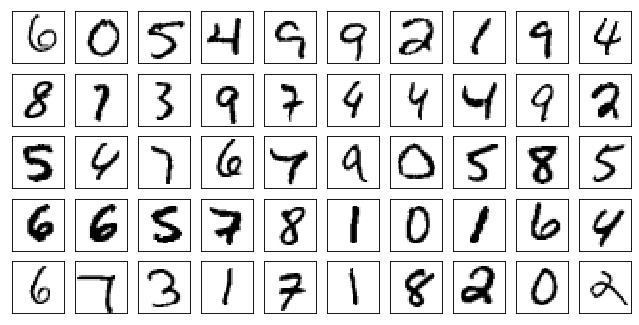

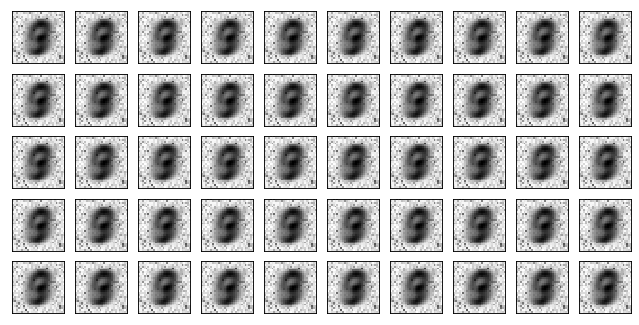

In [12]:
plot_mnist(data.data.numpy()[100:150], (5, 10))
plot_mnist(to_plot, (5, 10))

In [13]:
model_32D = Net(latent_size=32)
train_log = []
test_log = []

In [14]:
for epoch in range(1, 21):
    model_32D.train()
    train(epoch, model_32D, train_log)
    model_32D.eval()
    test(model_32D, test_loader, test_log)

Train Epoch: 1 [00000/60000] 1.006382
Train Epoch: 1 [30000/60000] 0.632019
Train Epoch: 1 [60000/60000] 0.395259
Test set:
loss: 0.3901

Train Epoch: 2 [00000/60000] 0.388218
Train Epoch: 2 [30000/60000] 0.312688
Train Epoch: 2 [60000/60000] 0.285937
Test set:
loss: 0.2902

Train Epoch: 3 [00000/60000] 0.284912
Train Epoch: 3 [30000/60000] 0.273118
Train Epoch: 3 [60000/60000] 0.264927
Test set:
loss: 0.2662

Train Epoch: 4 [00000/60000] 0.260305
Train Epoch: 4 [30000/60000] 0.260410
Train Epoch: 4 [60000/60000] 0.246894
Test set:
loss: 0.2510

Train Epoch: 5 [00000/60000] 0.258571
Train Epoch: 5 [30000/60000] 0.242045
Train Epoch: 5 [60000/60000] 0.236948
Test set:
loss: 0.2391

Train Epoch: 6 [00000/60000] 0.235960
Train Epoch: 6 [30000/60000] 0.231334
Train Epoch: 6 [60000/60000] 0.234133
Test set:
loss: 0.2284

Train Epoch: 7 [00000/60000] 0.219725
Train Epoch: 7 [30000/60000] 0.227506
Train Epoch: 7 [60000/60000] 0.220071
Test set:
loss: 0.2178

Train Epoch: 8 [00000/60000] 0.215

In [15]:
from sklearn.manifold import TSNE

In [16]:
latent_presentation_32D = [model_32D.encode(x.view(-1,28*28)).squeeze().tolist() for x in data]

In [17]:
tsne = TSNE(n_components=2, init='pca', random_state=1812)

In [18]:
latent_32D_embedding = tsne.fit_transform(latent_presentation_32D)

In [19]:
from matplotlib import pyplot as plt

### Отображение внтуренних представлений модели с 32-мерным внутренним пространством с помощью MNIST

### Чёткое разделение на 10 кластеров не наблюдается. Символы, соответствующие разным цифрам, но, имеющие схожее начертание, в 32-мерном представлении различаются недостаточно хорошо.

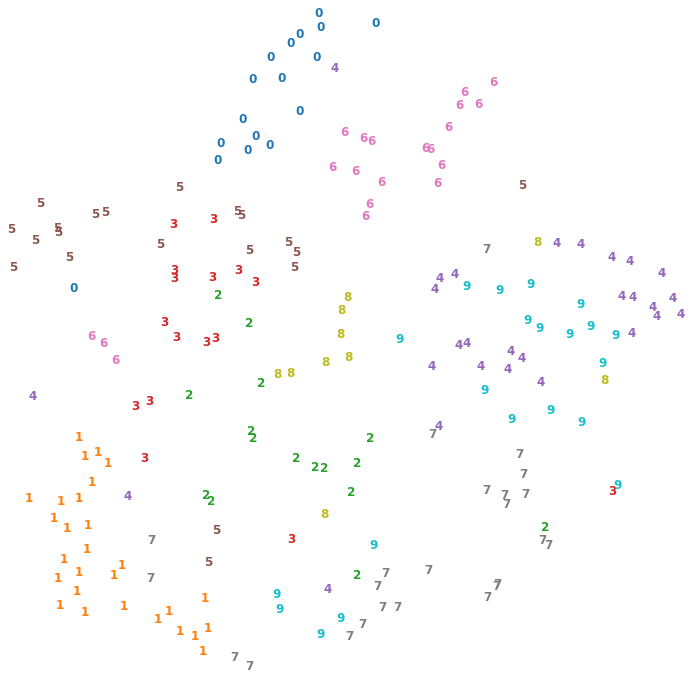

In [20]:
fig, ax = plt.subplots(figsize=(12,12))

X = latent_32D_embedding
x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)
Y = [str(l.item()) for l in labels]

for i in range(latent_32D_embedding.shape[0]):
    ax.text(
        X[i, 0], X[i, 1], Y[i],
        color=plt.cm.tab10(labels[i].item() / 10.),
        fontdict={'weight': 'bold', 'size': 12}
    )
ax.axis('off');

### Пример добавления шума к исходным изображениям

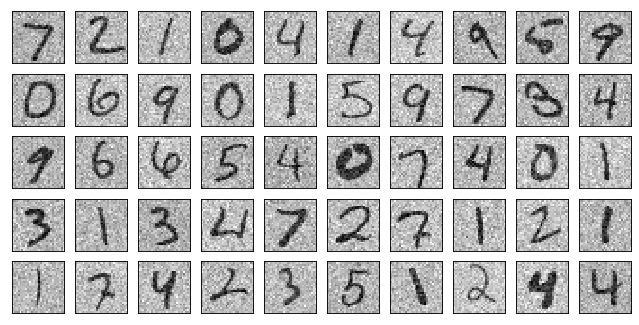

In [21]:
noized = add_noise(data, mode='gaussian', noise_std=0.1, elementwise=True)
plot_mnist(noized[:50], (5, 10))

In [22]:
model_32D = Net(latent_size=32)
train_log = []
test_log = []

In [23]:
for epoch in range(1, 21):
    model_32D.train()
    train(epoch, model_32D, mode='gaussian', noise_std=0.3, log=train_log)
    model_32D.eval()
    test(model_32D, test_loader, mode='gaussian', noise_std=0.3, log=test_log)

Train Epoch: 1 [00000/60000] 1.017897
Train Epoch: 1 [30000/60000] 0.655953
Train Epoch: 1 [60000/60000] 0.399643
Test set:
loss: 0.4038

Train Epoch: 2 [00000/60000] 0.402712
Train Epoch: 2 [30000/60000] 0.312384
Train Epoch: 2 [60000/60000] 0.295976
Test set:
loss: 0.2952

Train Epoch: 3 [00000/60000] 0.291315
Train Epoch: 3 [30000/60000] 0.284551
Train Epoch: 3 [60000/60000] 0.278759
Test set:
loss: 0.2763

Train Epoch: 4 [00000/60000] 0.274158
Train Epoch: 4 [30000/60000] 0.270848
Train Epoch: 4 [60000/60000] 0.270270
Test set:
loss: 0.2630

Train Epoch: 5 [00000/60000] 0.262109
Train Epoch: 5 [30000/60000] 0.261153
Train Epoch: 5 [60000/60000] 0.245660
Test set:
loss: 0.2470

Train Epoch: 6 [00000/60000] 0.243608
Train Epoch: 6 [30000/60000] 0.239263
Train Epoch: 6 [60000/60000] 0.235396
Test set:
loss: 0.2328

Train Epoch: 7 [00000/60000] 0.227417
Train Epoch: 7 [30000/60000] 0.226313
Train Epoch: 7 [60000/60000] 0.220694
Test set:
loss: 0.2211

Train Epoch: 8 [00000/60000] 0.218

In [24]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='gaussian', noise_std=0.3, elementwise=True)
output = model_32D(noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

### Результат фильтрации "шумным" автокодировщиком

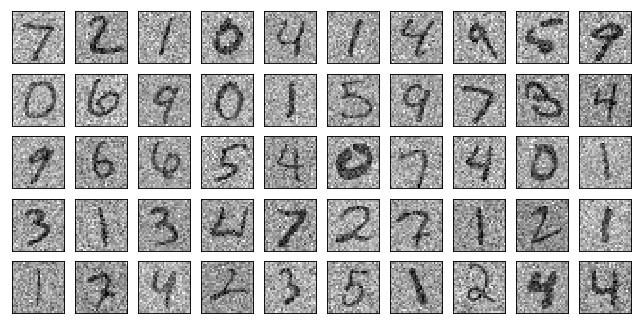

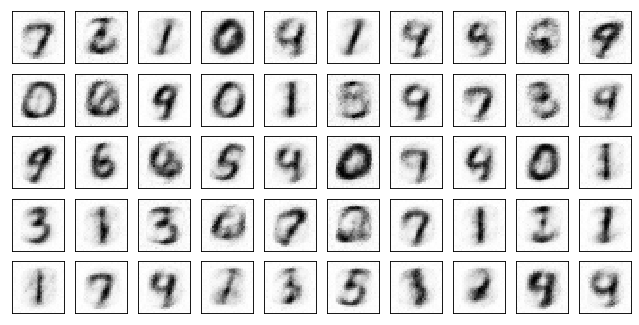

In [25]:
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

In [26]:
model_32D = Net(latent_size=32)
train_log = []
test_log = []

### Далее обучим модель на ещё более зашумлённых (дисперсия шума 0.6 вместо 0.3) образцах и сравним результаты фильтрации
### данных с разной долей шума

In [27]:
for epoch in range(1, 21):
    model_32D.train()
    train(epoch, model_32D, mode='gaussian', noise_std=0.6, log=train_log)
    model_32D.eval()
    test(model_32D, test_loader, mode='gaussian', noise_std=0.6, log=test_log)

Train Epoch: 1 [00000/60000] 1.011402
Train Epoch: 1 [30000/60000] 0.652098
Train Epoch: 1 [60000/60000] 0.392659
Test set:
loss: 0.3977

Train Epoch: 2 [00000/60000] 0.392788
Train Epoch: 2 [30000/60000] 0.322014
Train Epoch: 2 [60000/60000] 0.290159
Test set:
loss: 0.2938

Train Epoch: 3 [00000/60000] 0.294748
Train Epoch: 3 [30000/60000] 0.282865
Train Epoch: 3 [60000/60000] 0.280800
Test set:
loss: 0.2772

Train Epoch: 4 [00000/60000] 0.265008
Train Epoch: 4 [30000/60000] 0.274664
Train Epoch: 4 [60000/60000] 0.268361
Test set:
loss: 0.2651

Train Epoch: 5 [00000/60000] 0.263682
Train Epoch: 5 [30000/60000] 0.262938
Train Epoch: 5 [60000/60000] 0.248306
Test set:
loss: 0.2528

Train Epoch: 6 [00000/60000] 0.256985
Train Epoch: 6 [30000/60000] 0.244123
Train Epoch: 6 [60000/60000] 0.246381
Test set:
loss: 0.2414

Train Epoch: 7 [00000/60000] 0.239215
Train Epoch: 7 [30000/60000] 0.237805
Train Epoch: 7 [60000/60000] 0.230777
Test set:
loss: 0.2310

Train Epoch: 8 [00000/60000] 0.231

In [39]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='gaussian', noise_std=0.6, elementwise=True)
output = model_32D(noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

### Фильтрация данных с дисперсией шума 0.6

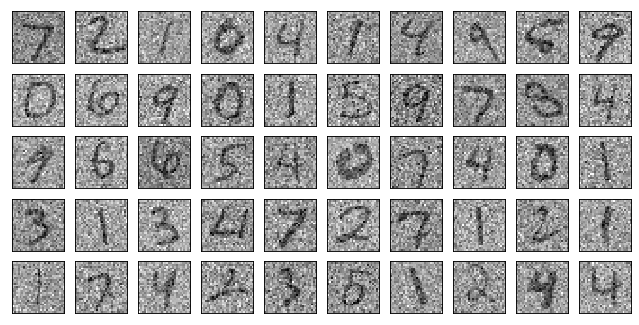

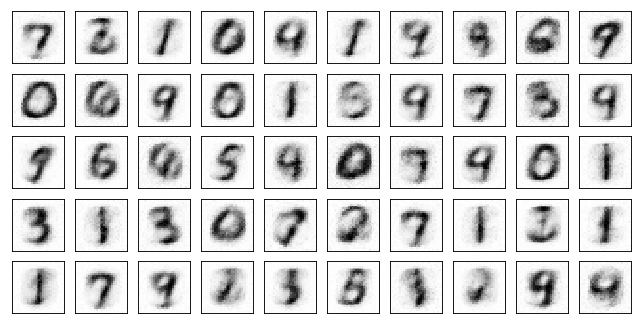

In [40]:
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

In [68]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='gaussian', noise_std=0.3, elementwise=True)
output = model_32D(noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

### Фильтрация данных с дисперсией шума 0.3

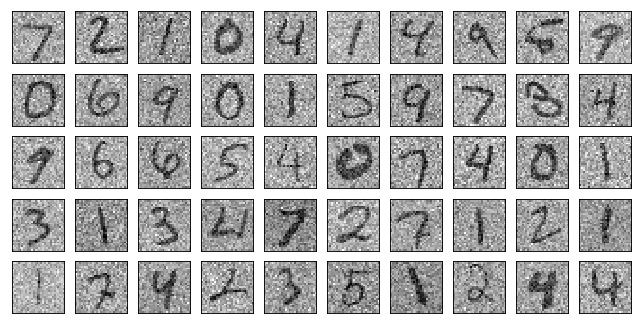

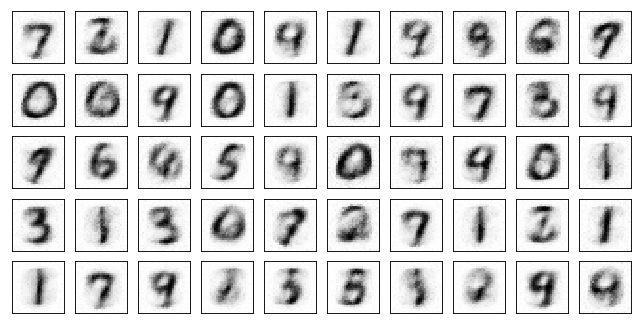

In [69]:
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

In [32]:
data, _ = next(iter(test_loader))
output = model_32D(data[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

### Фильтрация исходных незашумлённых данных.
### Результат обработки одинаков для всех трёх случаев - сильного шума, слабого шума и отсутствия шума.

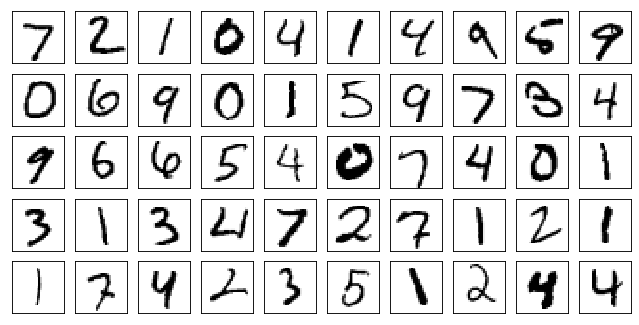

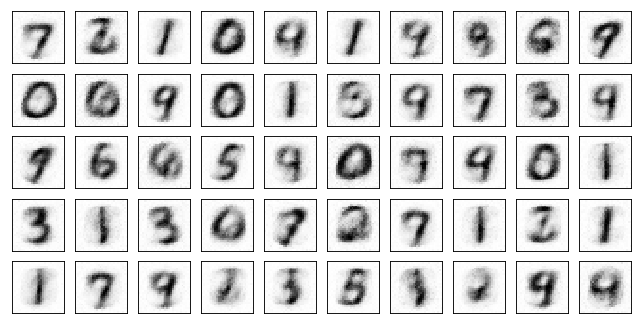

In [33]:
plot_mnist(data[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

In [34]:
model_64D = Net(latent_size=64)
train_log = []
test_log = []

### Обучение на данных с отражением части изображения

In [35]:
for epoch in range(1, 31):
    model_64D.train()
    train(epoch, model_64D, mode='mirror', log=train_log)
    model_64D.eval()
    test(model_64D, test_loader, mode='mirror', log=test_log)

Train Epoch: 1 [00000/60000] 0.988443
Train Epoch: 1 [30000/60000] 0.419051
Train Epoch: 1 [60000/60000] 0.288240
Test set:
loss: 0.2948

Train Epoch: 2 [00000/60000] 0.292188
Train Epoch: 2 [30000/60000] 0.277973
Train Epoch: 2 [60000/60000] 0.250524
Test set:
loss: 0.2634

Train Epoch: 3 [00000/60000] 0.257897
Train Epoch: 3 [30000/60000] 0.256205
Train Epoch: 3 [60000/60000] 0.239186
Test set:
loss: 0.2403

Train Epoch: 4 [00000/60000] 0.235594
Train Epoch: 4 [30000/60000] 0.222195
Train Epoch: 4 [60000/60000] 0.229502
Test set:
loss: 0.2211

Train Epoch: 5 [00000/60000] 0.206928
Train Epoch: 5 [30000/60000] 0.211196
Train Epoch: 5 [60000/60000] 0.207186
Test set:
loss: 0.2043

Train Epoch: 6 [00000/60000] 0.203709
Train Epoch: 6 [30000/60000] 0.186332
Train Epoch: 6 [60000/60000] 0.197861
Test set:
loss: 0.1915

Train Epoch: 7 [00000/60000] 0.206797
Train Epoch: 7 [30000/60000] 0.184194
Train Epoch: 7 [60000/60000] 0.174268
Test set:
loss: 0.1824

Train Epoch: 8 [00000/60000] 0.197

In [50]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='mirror', elementwise=True)
output = model_64D(noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

### Исходные данные,
### зашумлённые данные - с отражением части изображения,
### результат восстановления автокодировщиком

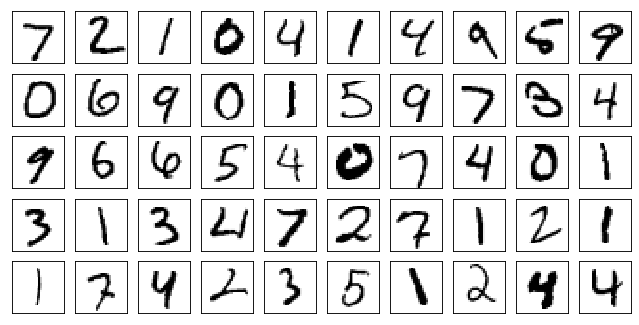

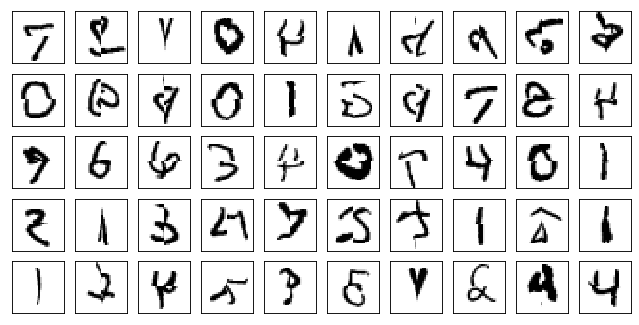

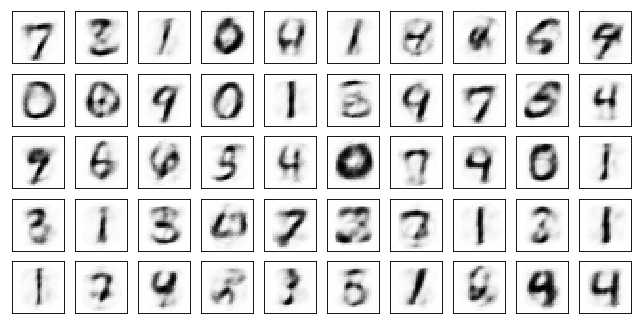

In [51]:
plot_mnist(data[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

In [58]:
weight_to_plot = model_64D.E.fc1.weight.view(-1, 1, 28, 28).data.numpy()

### Визуализация весов кодирующего (первого) слоя автокодировщика

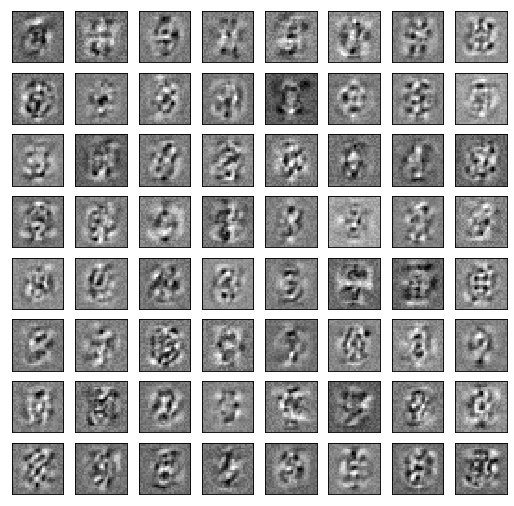

In [70]:
plot_mnist(weight_to_plot, (8, 8))